### Part 2: Image Processing and Transfer Learning - 50%
In part 2 of the assignment, we switch from text processing to image processing to explore
another set of model tasks. Again, you are asked to follow a set of instructions below and report
on your findings.

For this assignment we will make use of the CIFAR-100 dataset of images. 
- Rather than using all images, you are asked to randomly split CIFAR into two subsets of 50 classes each. 
- Your first task is to make these subsets and save these subsets to disk for use later. 
- Make sure to randomly select these classes (don’t just take the first 50). 
- Also make sure to account for training, validation or test as appropriate. 
- We will refer to the first set of data as Block 1 and the second set of 50 classes as Block 2.

As with Part 1, the set of tasks below do not build on each other and can in some ways be
considered independent.


In [110]:
import numpy as np
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Flatten, add, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, Reshape, Conv2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [111]:
BASE_DIR_PATH = "./"
MODEL_DIR_PATH = BASE_DIR_PATH + "models/Part2/CNN"
DATA_DIR_PATH = BASE_DIR_PATH + "data/Part2"
TRAIN_DIR_PATH = DATA_DIR_PATH + "/train"
TEST_DIR_PATH = DATA_DIR_PATH + "/test"

In [112]:
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

# normalise the pixel values to be between 0 and 1
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

# Load the CIFAR-100 data
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Save the CIFAR-100 data
def save_pickle(data, file):
    with open(file, 'wb') as fo:
        pickle.dump(data, fo)

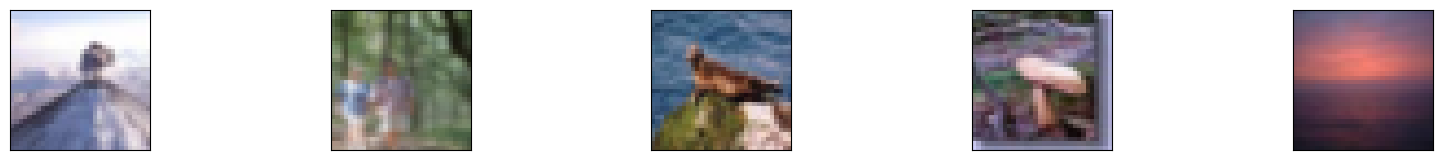

In [113]:
# display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(5):
    # display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(test_images[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Task 1: Load the CIFAR-100 dataset and split it into two sets of 50 classes each.

#### Randomly select 50 classes for Block 1 and 50 classes for Block 2.

In [114]:
# The CIFAR-100 dataset has 100 classes
num_classes = 100
np.random.seed(42)
classes = np.arange(num_classes)
np.random.shuffle(classes)


In [115]:
# Split the class indices into two subsets of 50 classes each
block_1_classes = classes[:50]
block_2_classes = classes[50:]

#### Filter the dataset to only include the selected classes for each block.

In [116]:
def filter_by_classes(images, labels, class_subset):
    """
    Filters images and labels by a subset of classes.

    Args:
        images (numpy.ndarray): Array of images.
        labels (numpy.ndarray): Array of labels corresponding to the images.
        class_subset (list or numpy.ndarray): List or array of class labels to filter by.

    Returns:
        tuple: A tuple containing:
            - filtered_images (numpy.ndarray): Array of images filtered by the specified classes.
            - filtered_labels (numpy.ndarray): Array of labels filtered by the specified classes.
    """
    indices = np.isin(labels, class_subset)
    filtered_images = images[indices.flatten()]
    filtered_labels = labels[indices.flatten()]
    return filtered_images, filtered_labels

In [117]:
def remap_labels(labels, class_subset):
    """
    Remaps the given labels to a new set of labels based on a subset of classes.

    Parameters:
    labels (array-like): The original labels to be remapped.
    class_subset (array-like): The subset of classes to which the labels should be remapped.

    Returns:
    numpy.ndarray: An array of remapped labels.
    """
    class_mapping = {original: new for new, original in enumerate(class_subset)}
    return np.array([class_mapping[label] for label in labels])

In [118]:
# Create subsets for train and test data
train_images_block_1, train_labels_block_1 = filter_by_classes(train_images, train_labels, block_1_classes)
train_images_block_2, train_labels_block_2 = filter_by_classes(train_images, train_labels, block_2_classes)
test_images_block_1, test_labels_block_1 = filter_by_classes(test_images, test_labels, block_1_classes)
test_images_block_2, test_labels_block_2 = filter_by_classes(test_images, test_labels, block_2_classes)

# print the shape of the train and test data
print(train_images_block_1.shape)
print(train_labels_block_1.shape)
print(train_images_block_2.shape)
print(train_labels_block_2.shape)


(25000, 32, 32, 3)
(25000, 1)
(25000, 32, 32, 3)
(25000, 1)


In [119]:
train_labels_block_1 = remap_labels(train_labels_block_1.flatten().tolist(), block_1_classes)
test_labels_block_1 = remap_labels(test_labels_block_1.flatten().tolist(), block_1_classes)
train_labels_block_2 = remap_labels(train_labels_block_2.flatten().tolist(), block_2_classes)
test_labels_block_2 = remap_labels(test_labels_block_2.flatten().tolist(), block_2_classes)

#### Save the images for each block to disk for use in the next task.

In [120]:
def save_to_disk(data, labels, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, 'wb') as f:
        pickle.dump((data, labels), f)

save_to_disk(train_images_block_1, train_labels_block_1, TRAIN_DIR_PATH+'/block_1_train.pkl')
save_to_disk(test_images_block_1, test_labels_block_1, TEST_DIR_PATH+'/block_1_test.pkl')

save_to_disk(train_images_block_2, train_labels_block_2, TRAIN_DIR_PATH+'/block_2_train.pkl')
save_to_disk(test_images_block_2, test_labels_block_2, TEST_DIR_PATH+'/block_2_test.pkl')

In [121]:
le = LabelEncoder()
train_labels_block_1 = le.fit_transform(train_labels_block_1)
test_labels_block_1 = le.transform(test_labels_block_1)

train_labels_block_1 = to_categorical(train_labels_block_1, num_classes=50)
test_labels_block_1 = to_categorical(test_labels_block_1, num_classes=50)

In [122]:
le_2 = LabelEncoder()
train_labels_block_2 = le_2.fit_transform(train_labels_block_2)
test_labels_block_2 = le_2.transform(test_labels_block_2)

train_labels_block_2 = to_categorical(train_labels_block_2, num_classes=50)
test_labels_block_2 = to_categorical(test_labels_block_2, num_classes=50)

In [123]:
print("Train data shape: ", train_images_block_1.shape)
print("Train labels shape: ", train_labels_block_1.shape)

print("Test data shape: ", test_images_block_1.shape)
print("Test labels shape: ", test_labels_block_1.shape)

print("Train data shape: ", train_images_block_2.shape)
print("Train labels shape: ", train_labels_block_2.shape)

print("Test data shape: ", test_images_block_2.shape)
print("Test labels shape: ", test_labels_block_2.shape)

Train data shape:  (25000, 32, 32, 3)
Train labels shape:  (25000, 50)
Test data shape:  (5000, 32, 32, 3)
Test labels shape:  (5000, 50)
Train data shape:  (25000, 32, 32, 3)
Train labels shape:  (25000, 50)
Test data shape:  (5000, 32, 32, 3)
Test labels shape:  (5000, 50)


### Basic Modelling: For Block 1 images:
1. Build a home-built network with 5 hidden layers of your choosing to classify the Block 1 images.
2. Report on relevant metrics and losses.
3. Investigate the use of different activation functions in this network.
4. Investigate the use of different losses in the network and the use of softmax vs logistic activation functions in the final layer.
5. Investigate the use of skip connections in network design.
6. Save the best performing model for the demo notebook and use later.


### Constants

In [15]:
"""
This script sets up two Keras callbacks for training a deep learning model: EarlyStopping and ReduceLROnPlateau.

Callbacks:
    - EarlyStopping: Monitors the training process and stops training when a monitored metric has stopped improving.
        Parameters:
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            patience (int): Number of epochs with no improvement after which training will be stopped.
            restore_best_weights (bool): Whether to restore model weights from the epoch with the best value of the monitored quantity.

    - ReduceLROnPlateau: Reduces the learning rate when a monitored metric has stopped improving.
        Parameters:
            monitor (str): Quantity to be monitored.
            factor (float): Factor by which the learning rate will be reduced. new_lr = lr * factor.
            patience (int): Number of epochs with no improvement after which learning rate will be reduced.
            min_lr (float): Lower bound on the learning rate.

The callbacks are stored in a list named `callbacks` and can be passed to the `fit` method of a Keras model.
"""

early_stopping = EarlyStopping(
    min_delta=0.001, # minimum amount of change to count as an improvement
    patience=15, # how many epochs to wait before stopping
    restore_best_weights=True,
)

reduceOnPlateau = ReduceLROnPlateau(
    monitor='val_loss', # value being monitored for improvement
    factor=0.1, # factor by which the learning rate will be reduced
    patience=5, # number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6, # lower bound on the learning rate
)

callbacks = [early_stopping, reduceOnPlateau]

In [16]:
"""
Constants used to maintain consistency across initial training.

Attributes:
    OUTPUT_DIM (int): Dimensionality of the output space.
    BATCH_SIZE (int): Number of samples per gradient update.
    EPOCHS (int): Number of epochs to train the model.
    DROPOUT_RATE (float): Fraction of the input units to drop.
    DENSE_ACTIVATION (str): Activation function to use in dense layers.
    OPTIMIZER (str): Optimizer to use for training the model.
    VALIDATION_SPLIT (float): Fraction of the training data to be used as validation data.
"""
OUTPUT_DIM=50
BATCH_SIZE=32
EPOCHS=50
DROPOUT_RATE=0.5
DENSE_ACTIVATION='relu'
OPTIMIZER='adam'
VALIDATION_SPLIT=0.2

### Utility Functions

In [17]:
# Plotting helper functions
def plot_training_results(history, metric='accuracy'):
    """
    Plots the training and validation results for a given metric over epochs.

    Parameters:
    history (dict): A dictionary containing the training history. It should have keys corresponding to the metric and 'val_' + metric.
    metric (str): The metric to plot (default is 'accuracy').

    Returns:
    None
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history[metric], label='Training ' + metric)
    plt.plot(history['val_'+metric], label='Validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.title('Training and Validation ' + metric)
    plt.legend()
    plt.show()

In [18]:
def evaluate_model(model, 
                   model_history, 
                   X_test,
                   y_test,
                   label_encoder=le):
    """
    Evaluates the performance of a trained model on the test dataset and 
    provides various performance metrics and visualizations.
    Parameters:
    model (keras.Model): The trained model to be evaluated.
    model_history (keras.callbacks.History): The history object returned by the model's fit method.
    X_test (numpy.ndarray): The test dataset features.
    y_test (numpy.ndarray): The test dataset labels.
    label_encoder (sklearn.preprocessing.LabelEncoder, optional): The label encoder used to transform the target variable. Default is 'le'.
    Returns:
    None
    Prints:
    - Test loss and accuracy.
    - Confusion matrix.
    - Accuracy score.
    - Classification report.
    Plots:
    - Training results for accuracy and loss.
    """
    loss, acc = model.evaluate(X_test, y_test)
    print('Test loss: ', loss)
    print('Test accuracy: ', acc)

  
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print('Confusion matrix:')
    print(confusion_matrix(y_true, y_pred))

    # make predictions
    y_pred = model.predict(X_test)

    # convert the predictions to the target variable
    y_pred = label_encoder.inverse_transform(y_pred.argmax(axis=1))

    # convert the test target variable to the original values
    y_test = label_encoder.inverse_transform(y_test.argmax(axis=1))

    print(accuracy_score(y_test, y_pred))
        
    # Print classification report
    print(classification_report(y_test, y_pred))
    
    # Plot results
    plot_training_results(model_history)
    plot_training_results(model_history, metric='loss')

#### Basic Model (Version 1)

In [19]:
# from tensorflow.keras.layers import Input, Dense, Flatten, Rescaling
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import add

# def create_model(output_dim=50,
#                 activation='relu',
#                 optimizer='adam',
#                 final_activation='softmax',
#                 loss_function='categorical_crossentropy',
#                 use_skip=False):
#     inputs = Input(shape=(32, 32, 3))
#     input_layer = Flatten()(inputs)
    
#     # First hidden layer
#     dense_one = Dense(512, activation=activation)(input_layer)
#     # Second hidden layer
#     dense_two = Dense(256, activation=activation)(dense_one)
    
#     # Optional skip connection
#     if use_skip:
#         # Match the dimensions before adding
#         dense_one_resized = Dense(256, activation=activation)(dense_one)
#         dense_two = add([dense_one_resized, dense_two])

#     # Third hidden layer
#     dense_three = Dense(128, activation=activation)(dense_two)
#     # Fourth hidden layer
#     dense_four = Dense(64, activation=activation)(dense_three)
#     # Fifth hidden layer
#     dense_five = Dense(32, activation=activation)(dense_four)
#     # Output layer
#     outputs = Dense(output_dim, activation=final_activation)(dense_five)

#     model = Model(inputs, outputs)

#     # Compile the model
#     model.compile(optimizer=optimizer,
#                 loss=loss_function,
#                 metrics=['accuracy'])
#     return model

### Basic Modelling: For Block 1 images:
1. Build a home-built network with 5 hidden layers of your choosing to classify the Block 1 images.

#### Advanced Model (Version 2)

In [ ]:
def create_model(output_dim=50,
                 activation='relu',
                 optimizer='adam',
                 final_activation='softmax',
                 loss_function='categorical_crossentropy',
                 use_skip=False):
    """
    Creates and compiles a Convolutional Neural Network (CNN) model.
    Parameters:
    output_dim (int): The dimension of the output layer. Default is 50.
    activation (str): The activation function to use in the convolutional and dense layers. Default is 'relu'.
    optimizer (str): The optimizer to use for compiling the model. Default is 'adam'.
    final_activation (str): The activation function to use in the output layer. Default is 'softmax'.
    loss_function (str): The loss function to use for compiling the model. Default is 'categorical_crossentropy'.
    use_skip (bool): Whether to use skip connections in the dense layers. Default is False.
    Returns:
    model (tf.keras.Model): The compiled CNN model.
    """
    inputs = Input(shape=(32, 32, 3))

    # Encoder layers
    conv1 = Conv2D(32, (3, 3), activation=activation, padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation=activation, padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation=activation, padding='same')(pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)

    # Flatten layer
    flat = Flatten()(pool3)

    # Dense layers for encoding
    dense_one = Dense(64, activation=activation)(flat)
    dense_two = Dense(128, activation=activation)(dense_one)

    if use_skip:
        dense_one_resized = Dense(128, activation=activation)(dense_one)
        dense_two = add([dense_one_resized, dense_two])

    dense_three = Dense(256, activation=activation)(dense_two)

    # Output layer
    final_output = Dense(output_dim, activation=final_activation)(dense_three)

    model = Model(inputs, final_output)

    model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=['accuracy'])

    return model

In [21]:
# create the basic model
basic_model = create_model()
basic_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856 

In [22]:
# Check the shapes of train_data_block_1 and train_labels_block_1
print("Shape of train_data_block_1:", train_images_block_1.shape)
print("Shape of train_labels_block_1:", train_labels_block_1.shape)

# train the model
model_history = basic_model.fit(train_images_block_1, train_labels_block_1, 
                                batch_size=BATCH_SIZE, 
                                epochs=EPOCHS, 
                                validation_split=VALIDATION_SPLIT, 
                                callbacks=callbacks)


Shape of train_data_block_1: (25000, 32, 32, 3)
Shape of train_labels_block_1: (25000, 50)
Epoch 1/50
625/625 [==============================] - 9s 14ms/step - loss: 3.4605 - accuracy: 0.0860 - val_loss: 3.1773 - val_accuracy: 0.1378 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 9s 14ms/step - loss: 2.9729 - accuracy: 0.1867 - val_loss: 2.8203 - val_accuracy: 0.2232 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 9s 14ms/step - loss: 2.6502 - accuracy: 0.2610 - val_loss: 2.6016 - val_accuracy: 0.2714 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 9s 14ms/step - loss: 2.4366 - accuracy: 0.3159 - val_loss: 2.4531 - val_accuracy: 0.3188 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 9s 15ms/step - loss: 2.2503 - accuracy: 0.3582 - val_loss: 2.3968 - val_accuracy: 0.3406 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 10s 16ms/step - loss: 2.0859 - accuracy: 0.3972 - val_loss: 2.4393 - val_ac

#### 2. Report on relevant metrics and losses.

157/157 [==============================] - 1s 7ms/step - loss: 2.3504 - accuracy: 0.3628
Test loss:  2.3504233360290527
Test accuracy:  0.3628000020980835
157/157 [==============================] - 1s 7ms/step
Confusion matrix:
[[28 19 10 ...  0  7  0]
 [ 2 73  4 ...  0  4  0]
 [ 1  2 61 ...  0 13  2]
 ...
 [ 1  3  3 ... 11  0  2]
 [ 6 12 18 ...  0 46  0]
 [ 0  2  0 ...  0  1 35]]
157/157 [==============================] - 1s 6ms/step
0.3628
              precision    recall  f1-score   support

           0       0.41      0.28      0.33       100
           1       0.47      0.73      0.57       100
           2       0.44      0.61      0.51       100
           3       0.21      0.15      0.17       100
           4       0.15      0.18      0.16       100
           5       0.61      0.35      0.45       100
           6       0.45      0.23      0.30       100
           7       0.23      0.08      0.12       100
           8       0.35      0.17      0.23       100
           9 

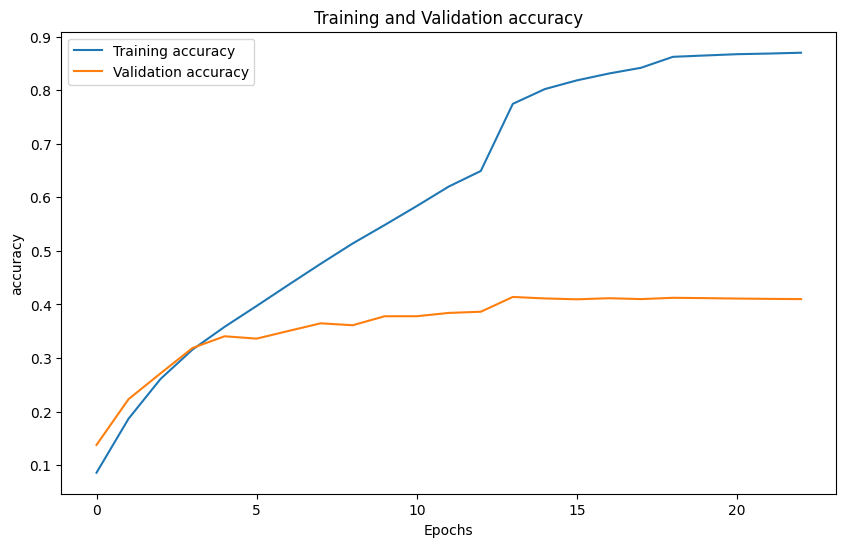

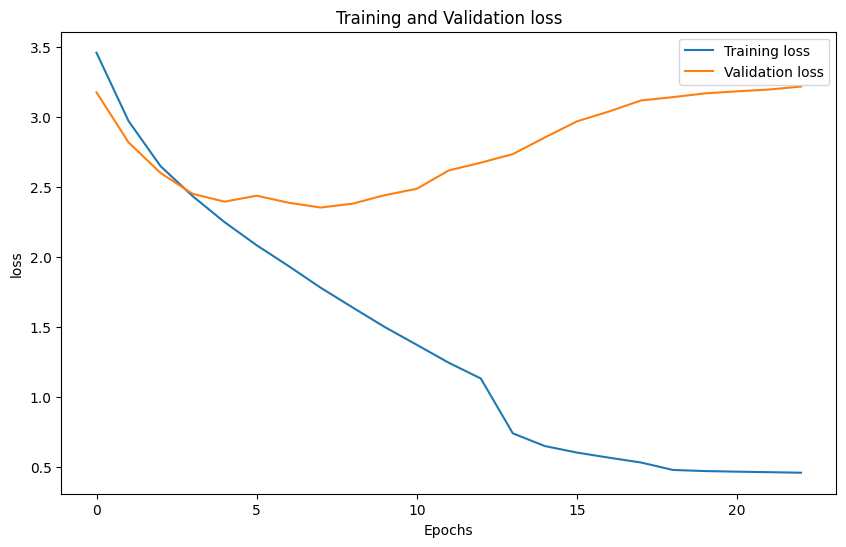

In [23]:
# evaluate the model
evaluate_model(basic_model, model_history.history, test_images_block_1, test_labels_block_1)

#### 3. Investigate the use of different activation functions in this network.

In [24]:
# create a definition to loop through the different models
def run_activation_experiment(activations, 
                              model, 
                              train_images, 
                              train_labels, 
                              test_images, 
                              test_labels, 
                              callbacks):

    # create a list to hold investigation results
    results = []
    # loop through the activation functions
    for activation in activations:
        print(f'Running experiment with activation: {activation}')
        # create the model
        model = create_model(activation=activation)
        # train the model
        model_history = model.fit(train_images, train_labels, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    validation_split=VALIDATION_SPLIT, 
                                    callbacks=callbacks)

        # evaluate the model
        loss, accuracy = model.evaluate(test_images, test_labels)
        results.append({
            'experiment': 'activation',
            'model': model,
            'history': model_history.history,
            'experiment_variable': activation,
            'loss': loss,
            'accuracy': accuracy
        })
    results = sorted(results, key=lambda x: x['accuracy'], reverse=True)
    return results
   

In [25]:
# create a list of activation functions
activations = ['relu','leaky_relu','tanh','sigmoid','softmax']

activation_results = run_activation_experiment(activations,
                                                basic_model,
                                                train_images_block_1,
                                                train_labels_block_1,
                                                test_images_block_1,
                                                test_labels_block_1,
                                                callbacks)

# print the top result
print(activation_results[0])

Running experiment with activation: relu
Epoch 1/50
625/625 [==============================] - 11s 17ms/step - loss: 3.5016 - accuracy: 0.0783 - val_loss: 3.2058 - val_accuracy: 0.1356 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 10s 17ms/step - loss: 3.0187 - accuracy: 0.1723 - val_loss: 2.9430 - val_accuracy: 0.1946 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 11s 17ms/step - loss: 2.7500 - accuracy: 0.2328 - val_loss: 2.6894 - val_accuracy: 0.2542 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 11s 17ms/step - loss: 2.5252 - accuracy: 0.2887 - val_loss: 2.5774 - val_accuracy: 0.2806 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 11s 17ms/step - loss: 2.3413 - accuracy: 0.3339 - val_loss: 2.4210 - val_accuracy: 0.3282 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 11s 17ms/step - loss: 2.1851 - accuracy: 0.3711 - val_loss: 2.3814 - val_accuracy: 0.3428 - lr: 0.0010
Epoch 7/50
625/62

In [26]:
# select the best model
best_activation_model = activation_results[0]['model']
best_activation_model_history = activation_results[0]['history']

# set a variable to hold the best activation method
best_activation_method = activation_results[0]['experiment_variable']

# print the best activation method
print(f'Best activation method: {best_activation_method}')

Best activation method: leaky_relu


157/157 [==============================] - 1s 7ms/step - loss: 2.0989 - accuracy: 0.4302
Test loss:  2.0989465713500977
Test accuracy:  0.4302000105381012
157/157 [==============================] - 1s 7ms/step
Confusion matrix:
[[45 14  3 ...  1  7  3]
 [ 3 75  0 ...  0  6  2]
 [ 5  0 55 ...  1 11  2]
 ...
 [ 1  1  0 ... 34  2  2]
 [ 6  7  9 ...  1 61  3]
 [ 2  1  0 ...  0  1 55]]
157/157 [==============================] - 1s 7ms/step
0.4302
              precision    recall  f1-score   support

           0       0.43      0.45      0.44       100
           1       0.66      0.75      0.70       100
           2       0.63      0.55      0.59       100
           3       0.31      0.22      0.26       100
           4       0.35      0.14      0.20       100
           5       0.46      0.51      0.49       100
           6       0.49      0.41      0.45       100
           7       0.32      0.18      0.23       100
           8       0.32      0.40      0.35       100
           9 

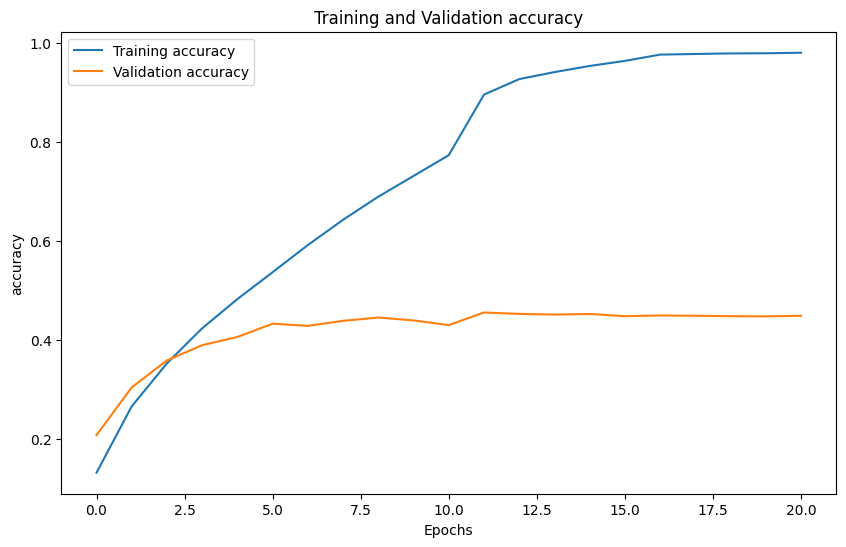

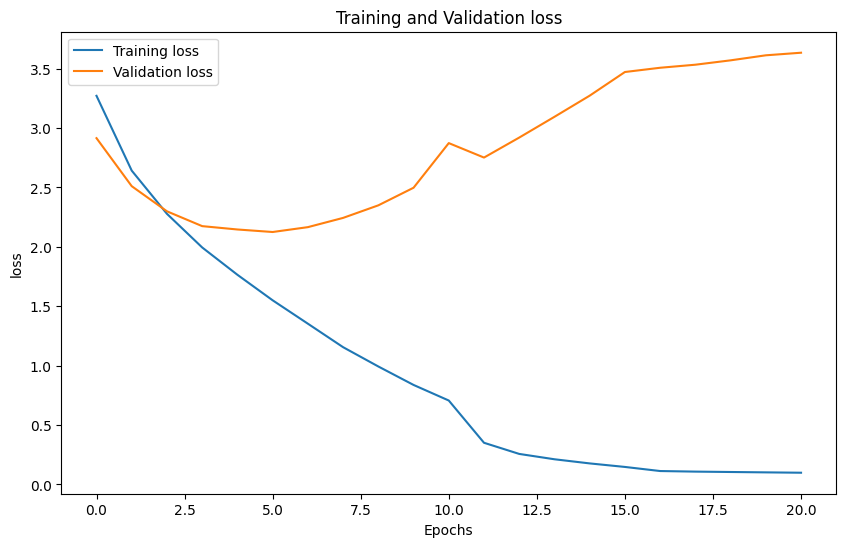

In [27]:
# evaluate the best model
evaluate_model(best_activation_model, best_activation_model_history, test_images_block_1, test_labels_block_1)

#### 5. Investigate the use of different losses in the network and the use of softmax vs logistic activation functions in the final layer.

##### 5a. Investigate different loss functions

In [28]:
def run_loss_function_experiment(loss_functions, 
                                model, 
                                train_images, 
                                train_labels, 
                                test_images, 
                                test_labels, 
                                callbacks):
    """
    Runs an experiment to evaluate the performance of a model with different loss functions.

    Parameters:
    loss_functions (list): A list of loss functions to evaluate.
    model (tf.keras.Model): The model to train and evaluate.
    train_images (numpy.ndarray): The training data features.
    train_labels (numpy.ndarray): The training data labels.
    test_images (numpy.ndarray): The test data features.
    test_labels (numpy.ndarray): The test data labels.
    callbacks (list): A list of Keras callbacks to use during training.

    Returns:
    list: A list of dictionaries containing the results of the experiments
    """
    results = []
    for loss_function in loss_functions:
        print(f'Running experiment with loss function: {loss_function}')
        model = create_model(loss_function=loss_function)
        model_history = model.fit(train_images, train_labels, 
                                  batch_size=BATCH_SIZE, 
                                  epochs=EPOCHS, 
                                  validation_split=VALIDATION_SPLIT, 
                                  callbacks=callbacks)
        loss, accuracy = model.evaluate(test_images, test_labels)
        results.append({
            'experiment': 'loss_function',
            'model': model,
            'history': model_history.history,
            'experiment_variable': loss_function,
            'loss': loss,
            'accuracy': accuracy
        })
    results = sorted(results, key=lambda x: x['accuracy'], reverse=True)
    return results

In [29]:
# loss functions suitable for multi-class classification
loss_functions = [KLDivergence(),'categorical_crossentropy']

# run the loss function experiment
loss_function_results = run_loss_function_experiment(loss_functions,
                                                    basic_model,
                                                    train_images_block_1,
                                                    train_labels_block_1,
                                                    test_images_block_1,
                                                    test_labels_block_1,
                                                    callbacks)

# print the top result
print(loss_function_results[0])

Running experiment with loss function: <keras.src.losses.KLDivergence object at 0x15e53d5d0>
Epoch 1/50
625/625 [==============================] - 11s 17ms/step - loss: 3.4738 - accuracy: 0.0822 - val_loss: 3.2543 - val_accuracy: 0.1308 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 11s 17ms/step - loss: 3.0573 - accuracy: 0.1672 - val_loss: 2.9125 - val_accuracy: 0.2124 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 11s 17ms/step - loss: 2.7977 - accuracy: 0.2295 - val_loss: 2.7353 - val_accuracy: 0.2532 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 11s 17ms/step - loss: 2.5800 - accuracy: 0.2768 - val_loss: 2.5773 - val_accuracy: 0.2808 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 11s 17ms/step - loss: 2.3935 - accuracy: 0.3216 - val_loss: 2.5783 - val_accuracy: 0.2908 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 11s 18ms/step - loss: 2.2220 - accuracy: 0.3661 - val_loss: 2.4615 -

Best loss function: categorical_crossentropy


157/157 [==============================] - 1s 7ms/step - loss: 2.3138 - accuracy: 0.3814
Test loss:  2.313828945159912
Test accuracy:  0.3813999891281128
157/157 [==============================] - 1s 7ms/step
Confusion matrix:
[[42 13 12 ...  0  4  1]
 [ 5 70  0 ...  1  3  2]
 [ 7  1 60 ...  2  6  2]
 ...
 [ 5  1  1 ... 22  0  1]
 [15  6 18 ...  0 45  1]
 [ 1  1  0 ...  1  0 27]]
157/157 [==============================] - 1s 7ms/step
0.3814
              precision    recall  f1-score   support

           0       0.39      0.42      0.41       100
           1       0.63      0.70      0.66       100
           2       0.48      0.60      0.53       100
           3       0.27      0.23      0.25       100
           4       0.29      0.16      0.21       100
           5       0.44      0.49      0.46       100
           6       0.31      0.42      0.36       100
           7       0.17      0.25      0.20       100
           8       0.35      0.24      0.29       100
           9  

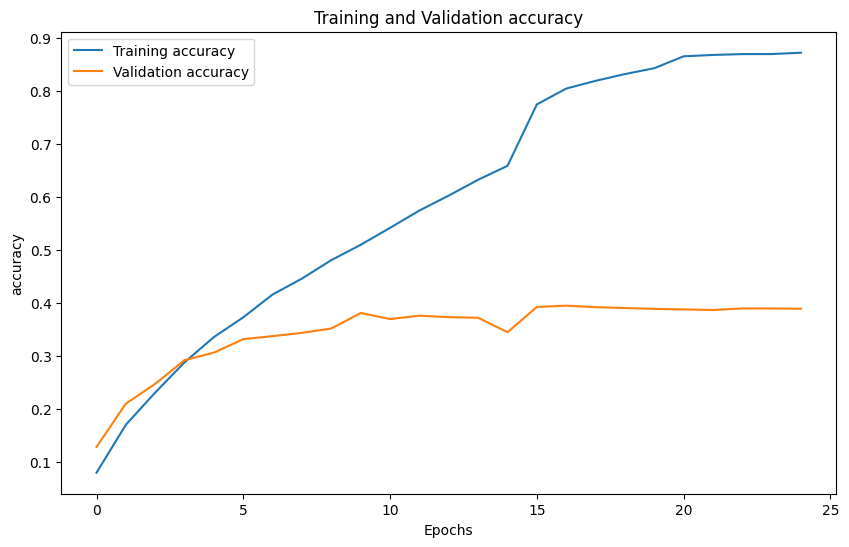

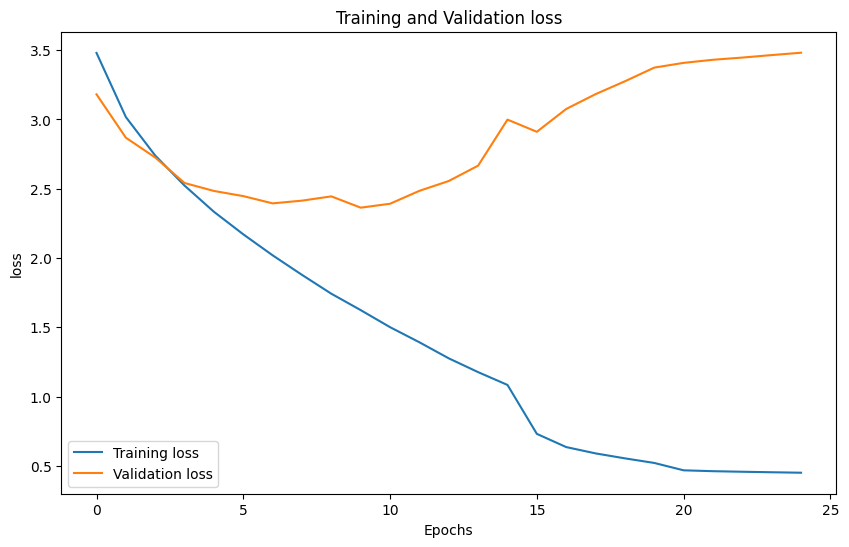

In [30]:
# select the best model
best_loss_function_model = loss_function_results[0]['model']

# set a variable to hold the best loss function
best_loss_function = loss_function_results[0]['experiment_variable']

# print the best loss function
print(f'Best loss function: {best_loss_function}')

# evaluate the best model
evaluate_model(best_loss_function_model, loss_function_results[0]['history'], test_images_block_1, test_labels_block_1)

##### 5b. Investigate different final activation

In [31]:
# create a function to loop over different final activation functions
def run_final_activation_experiment(final_activations, 
                                    model, 
                                    train_images, 
                                    train_labels, 
                                    test_images, 
                                    test_labels, 
                                    callbacks):

    # create a list to hold investigation results
    results = []
    # loop through the activation functions
    for activation in final_activations:
        print(f'Running experiment with final activation: {activation}')
        # create the model
        model = create_model(final_activation=activation)
        # train the model
        model_history = model.fit(train_images, train_labels, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    validation_split=VALIDATION_SPLIT, 
                                    callbacks=callbacks)

        # evaluate the model
        loss, accuracy = model.evaluate(test_images, test_labels)
        results.append({
            'experiment': 'final_activation',
            'model': model,
            'history': model_history.history,
            'experiment_variable': activation,
            'loss': loss,
            'accuracy': accuracy
        })
    results = sorted(results, key=lambda x: x['accuracy'], reverse=True)
    return results

In [32]:
# create a list of final activation functions
final_activations = ['softmax', 'sigmoid', 'tanh', 'relu', 'elu', 'linear']

final_activation_results = run_final_activation_experiment(final_activations,
                                                            best_activation_model,
                                                            train_images_block_1,
                                                            train_labels_block_1,
                                                            test_images_block_1,
                                                            test_labels_block_1,
                                                            callbacks)

# print the top result
print(final_activation_results[0])

Running experiment with final activation: softmax
Epoch 1/50
625/625 [==============================] - 12s 18ms/step - loss: 3.4595 - accuracy: 0.0872 - val_loss: 3.1991 - val_accuracy: 0.1224 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 11s 18ms/step - loss: 3.0197 - accuracy: 0.1747 - val_loss: 2.8885 - val_accuracy: 0.2098 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 11s 18ms/step - loss: 2.7282 - accuracy: 0.2390 - val_loss: 2.6668 - val_accuracy: 0.2688 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 12s 19ms/step - loss: 2.5247 - accuracy: 0.2914 - val_loss: 2.5285 - val_accuracy: 0.2920 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 11s 17ms/step - loss: 2.3554 - accuracy: 0.3322 - val_loss: 2.5054 - val_accuracy: 0.3060 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 11s 18ms/step - loss: 2.2175 - accuracy: 0.3660 - val_loss: 2.3912 - val_accuracy: 0.3400 - lr: 0.0010
Epoch 7/

In [33]:
# select the best model
best_final_activation_model = final_activation_results[0]['model']
best_final_activation_model_history = final_activation_results[0]['history']

# set a variable to hold the best final activation method
best_final_activation_method = final_activation_results[0]['experiment_variable'] 

# print the top result
print(final_activation_results[0])

# print the best activation method
print(f'Best final activation method: {best_final_activation_method}')

{'experiment': 'final_activation', 'model': <keras.src.engine.functional.Functional object at 0x300d67a90>, 'history': {'loss': [3.400604009628296, 2.9641294479370117, 2.704977035522461, 2.4739291667938232, 2.2924506664276123, 2.12772274017334, 1.960795521736145, 1.820186734199524, 1.6794322729110718, 1.5619477033615112, 1.4273128509521484, 1.3281993865966797, 1.2270328998565674, 1.1188075542449951, 0.7542967796325684, 0.6679926514625549, 0.6248185634613037, 0.5901595950126648, 0.5587098002433777, 0.506889283657074, 0.5001556873321533, 0.4962541460990906, 0.49270570278167725, 0.4895099997520447], 'accuracy': [0.09395000338554382, 0.18970000743865967, 0.24809999763965607, 0.30125001072883606, 0.341949999332428, 0.3852500021457672, 0.4250499904155731, 0.46415001153945923, 0.5011500120162964, 0.5288000106811523, 0.5674999952316284, 0.5953999757766724, 0.6172999739646912, 0.6519500017166138, 0.7703999876976013, 0.7970499992370605, 0.8112999796867371, 0.8251000046730042, 0.8356500267982483,

157/157 [==============================] - 1s 7ms/step - loss: 2.2535 - accuracy: 0.3964
Test loss:  2.253530263900757
Test accuracy:  0.39640000462532043
157/157 [==============================] - 1s 7ms/step
Confusion matrix:
[[41  9  3 ...  0  7  0]
 [ 5 66  1 ...  0  5  0]
 [10  3 42 ...  1 14  0]
 ...
 [ 2  2  0 ... 22  0  1]
 [10  7  7 ...  0 56  1]
 [ 2  1  0 ...  0  0 12]]
157/157 [==============================] - 1s 7ms/step
0.3964
              precision    recall  f1-score   support

           0       0.35      0.41      0.38       100
           1       0.62      0.66      0.64       100
           2       0.62      0.42      0.50       100
           3       0.35      0.23      0.28       100
           4       0.19      0.26      0.22       100
           5       0.49      0.55      0.52       100
           6       0.36      0.25      0.30       100
           7       0.19      0.33      0.24       100
           8       0.28      0.35      0.31       100
           9 

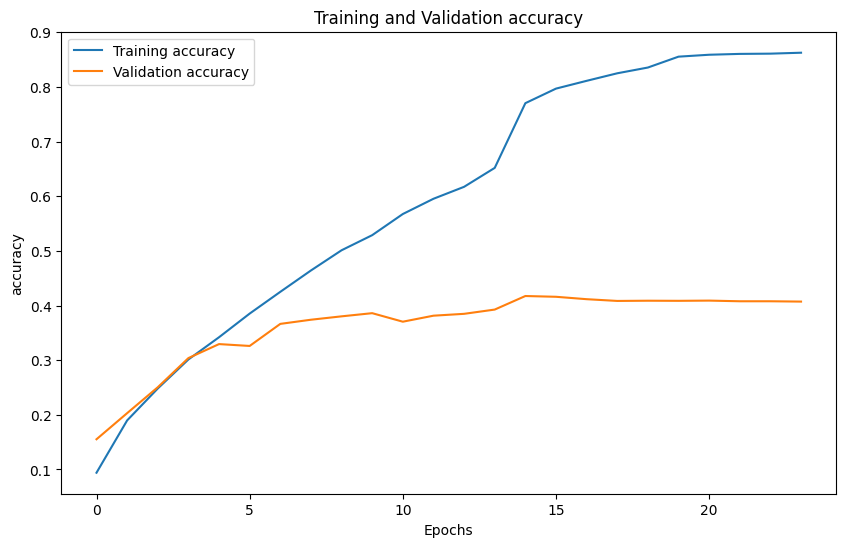

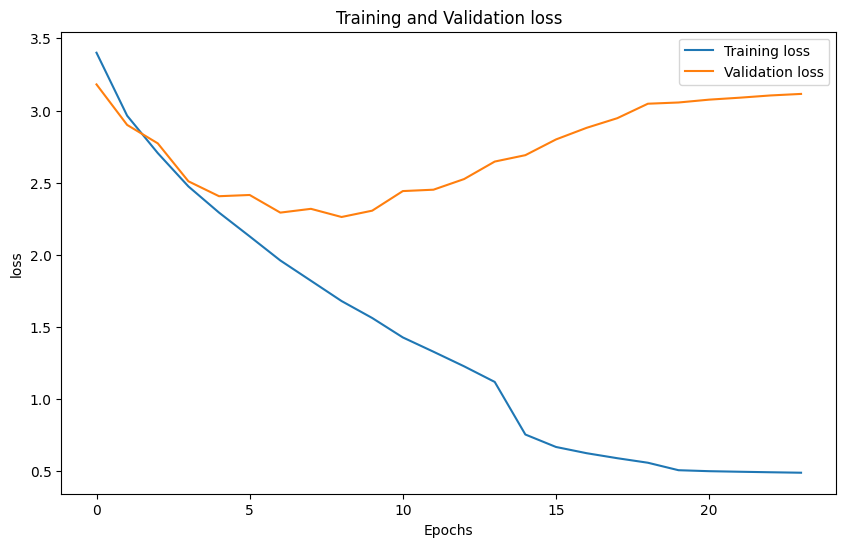

In [34]:
# evaluate the best model
evaluate_model(best_final_activation_model, best_final_activation_model_history, test_images_block_1, test_labels_block_1)

#### 6. Investigate the use of skip connections in network design.

In [35]:
# create a model that uses the skip connection, with the best activation and final activation methods
skip_model = create_model(activation=best_activation_method, 
                          loss_function=best_loss_function,
                          final_activation=best_final_activation_method, 
                          use_skip=True)

# train the model
skip_model_history = skip_model.fit(train_images_block_1, train_labels_block_1, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    validation_split=VALIDATION_SPLIT, 
                                    callbacks=callbacks)

Epoch 1/50
625/625 [==============================] - 11s 17ms/step - loss: 3.2443 - accuracy: 0.1357 - val_loss: 2.8449 - val_accuracy: 0.2210 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 11s 17ms/step - loss: 2.6161 - accuracy: 0.2754 - val_loss: 2.4678 - val_accuracy: 0.3136 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 11s 17ms/step - loss: 2.2251 - accuracy: 0.3749 - val_loss: 2.2239 - val_accuracy: 0.3832 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 11s 18ms/step - loss: 1.9318 - accuracy: 0.4424 - val_loss: 2.1115 - val_accuracy: 0.3964 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 11s 17ms/step - loss: 1.7030 - accuracy: 0.4999 - val_loss: 2.1125 - val_accuracy: 0.4182 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 11s 17ms/step - loss: 1.4901 - accuracy: 0.5525 - val_loss: 2.1089 - val_accuracy: 0.4286 - lr: 0.0010
Epoch 7/50
625/625 [==============================] - 11s 

157/157 [==============================] - 1s 6ms/step - loss: 2.1046 - accuracy: 0.4348
Test loss:  2.104644536972046
Test accuracy:  0.43479999899864197
157/157 [==============================] - 1s 6ms/step
Confusion matrix:
[[27 13  8 ...  0  4  0]
 [ 4 68  2 ...  0  6  1]
 [ 3  2 52 ...  0 20  0]
 ...
 [ 0  1  0 ... 26  3  1]
 [ 7  7 14 ...  0 57  1]
 [ 1  0  0 ...  4  1 62]]
157/157 [==============================] - 1s 7ms/step
0.4334
              precision    recall  f1-score   support

           0       0.44      0.27      0.34       100
           1       0.62      0.68      0.65       100
           2       0.50      0.52      0.51       100
           3       0.38      0.27      0.31       100
           4       0.23      0.30      0.26       100
           5       0.45      0.68      0.54       100
           6       0.43      0.48      0.45       100
           7       0.17      0.11      0.13       100
           8       0.30      0.46      0.36       100
           9 

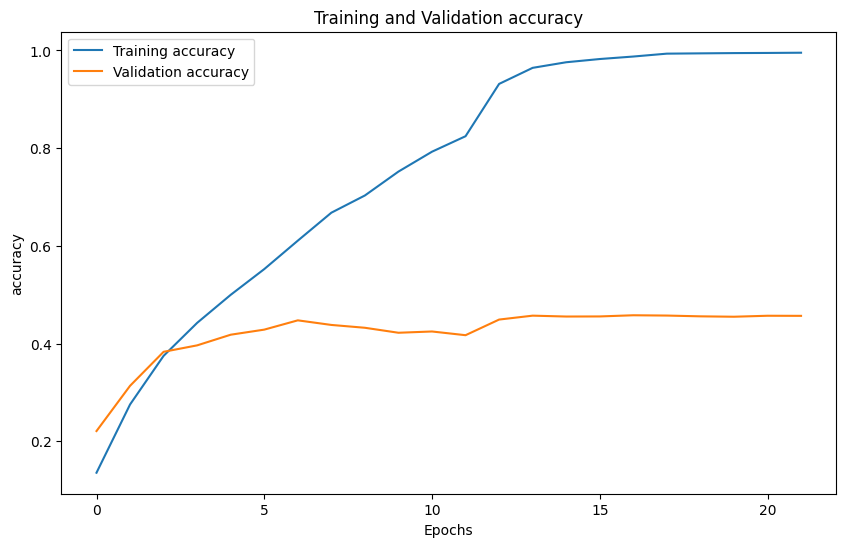

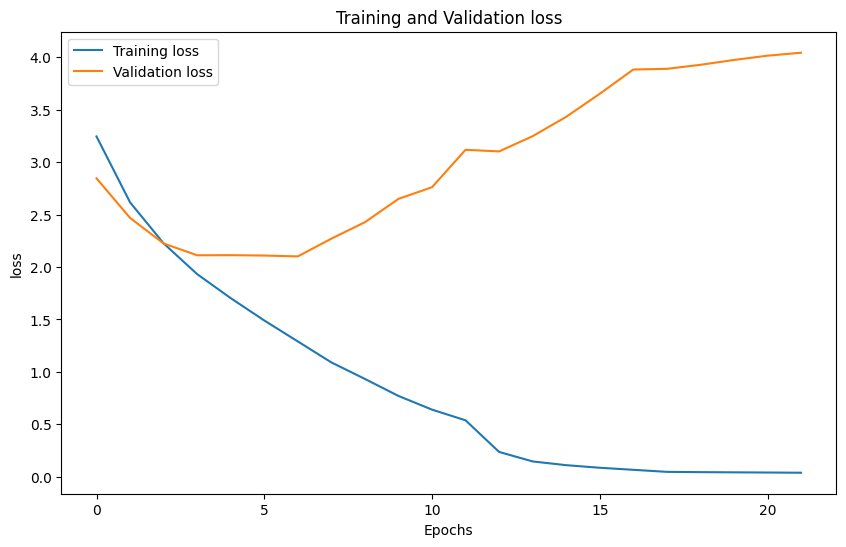

157/157 [==============================] - 1s 7ms/step - loss: 2.1046 - accuracy: 0.4348


In [36]:
# evaluate the model
evaluate_model(skip_model, skip_model_history.history, test_images_block_1, test_labels_block_1)

# get model loss and accuracy
skip_model_loss, skip_model_accuracy = skip_model.evaluate(test_images_block_1, test_labels_block_1)

In [42]:
# create a model with all the best parameters
test_model = create_model(activation=best_activation_method, 
                          loss_function=best_loss_function,
                          final_activation=best_final_activation_method, 
                          use_skip=True)

# train the model
test_model_history = test_model.fit(train_images_block_1, train_labels_block_1, 
                                    batch_size=BATCH_SIZE, 
                                    epochs=EPOCHS, 
                                    validation_split=VALIDATION_SPLIT, 
                                    callbacks=callbacks)



Epoch 1/50
625/625 [==============================] - 11s 18ms/step - loss: 3.2577 - accuracy: 0.1347 - val_loss: 2.8874 - val_accuracy: 0.2188 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 11s 18ms/step - loss: 2.6243 - accuracy: 0.2718 - val_loss: 2.4710 - val_accuracy: 0.3176 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 11s 18ms/step - loss: 2.2427 - accuracy: 0.3637 - val_loss: 2.2905 - val_accuracy: 0.3748 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 11s 18ms/step - loss: 1.9616 - accuracy: 0.4336 - val_loss: 2.1872 - val_accuracy: 0.3886 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 11s 18ms/step - loss: 1.7084 - accuracy: 0.4979 - val_loss: 2.1839 - val_accuracy: 0.4014 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 11s 18ms/step - loss: 1.4931 - accuracy: 0.5550 - val_loss: 2.1549 - val_accuracy: 0.4262 - lr: 0.0010
Epoch 7/50
625/625 [==============================] - 11s 

In [43]:
# get the model loss and accuracy
test_model_loss, test_model_accuracy = test_model.evaluate(test_images_block_1, test_labels_block_1)

157/157 [==============================] - 1s 7ms/step - loss: 2.1229 - accuracy: 0.4288


#### 7. Save the best performing model for the demo notebook and use later.

In [44]:
# combine the results of the three models, so we can order them by accuracy
combined_results = activation_results + final_activation_results + loss_function_results+[{'experiment': 'skip_layer','model': skip_model, 'history': skip_model_history.history, 'accuracy': skip_model_accuracy, 'loss': skip_model_loss, 'experiment_variable': 'skip_layer'}] + [{'experiment': 'all_best_params','model': test_model, 'history': test_model_history.history, 'accuracy': test_model_accuracy, 'loss': test_model_loss, 'experiment_variable': 'all_best_params'}]

# sort the results by accuracy
combined_results = sorted(combined_results, key=lambda x: x['accuracy'], reverse=True)

# save the best model
best_basic_model = combined_results[0]['model']

# save the model to disk
os.makedirs('models/Part2', exist_ok=True)
best_basic_model.save(MODEL_DIR_PATH+'/best_basic_model.keras')

# save the comibined results to csv
results_df = pd.DataFrame(combined_results)
results_df.to_csv(MODEL_DIR_PATH+'/results.csv', index=False)

# # save the best model history
# save_to_disk(combined_results[0]['history'], MODEL_DIR_PATH+'/best_basic_model_history.pkl')

# # save the combined results
# os.makedirs('results/Part2', exist_ok=True)
# save_to_disk(combined_results, MODEL_DIR_PATH+'/combined_results.pkl')



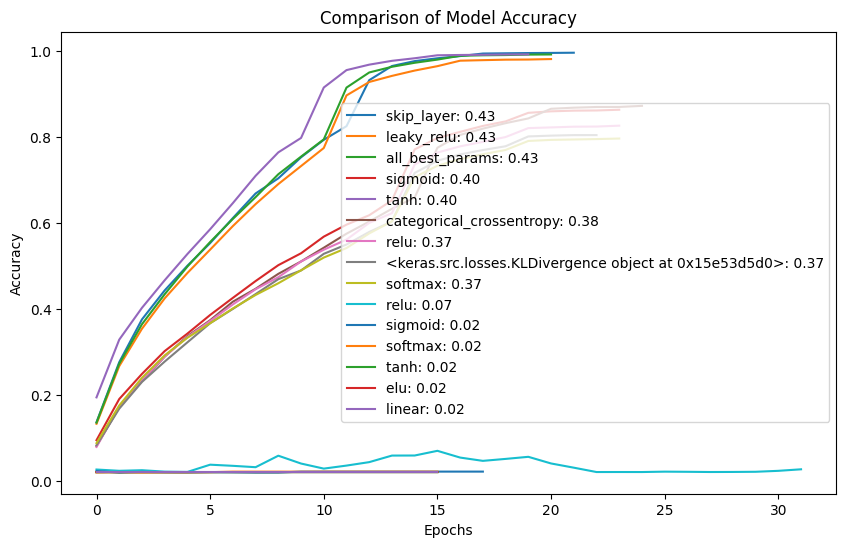

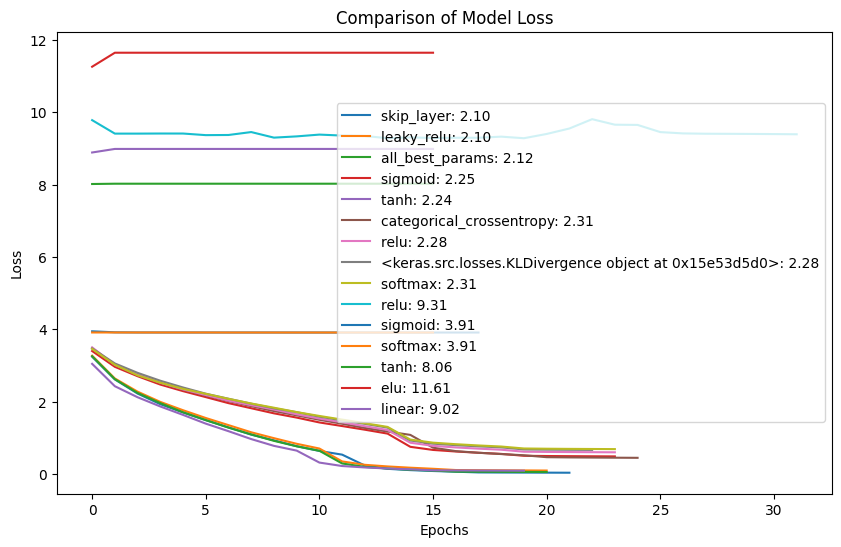

157/157 [==============================] - 1s 7ms/step - loss: 2.1046 - accuracy: 0.4348
Test loss:  2.104644536972046
Test accuracy:  0.43479999899864197
157/157 [==============================] - 1s 7ms/step
Confusion matrix:
[[27 13  8 ...  0  4  0]
 [ 4 68  2 ...  0  6  1]
 [ 3  2 52 ...  0 20  0]
 ...
 [ 0  1  0 ... 26  3  1]
 [ 7  7 14 ...  0 57  1]
 [ 1  0  0 ...  4  1 62]]
157/157 [==============================] - 1s 7ms/step
0.4334
              precision    recall  f1-score   support

           0       0.44      0.27      0.34       100
           1       0.62      0.68      0.65       100
           2       0.50      0.52      0.51       100
           3       0.38      0.27      0.31       100
           4       0.23      0.30      0.26       100
           5       0.45      0.68      0.54       100
           6       0.43      0.48      0.45       100
           7       0.17      0.11      0.13       100
           8       0.30      0.46      0.36       100
           9 

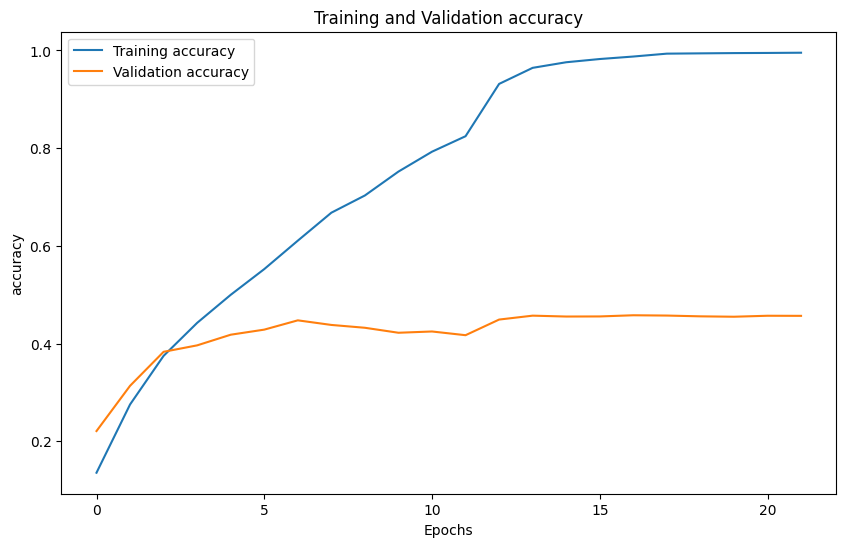

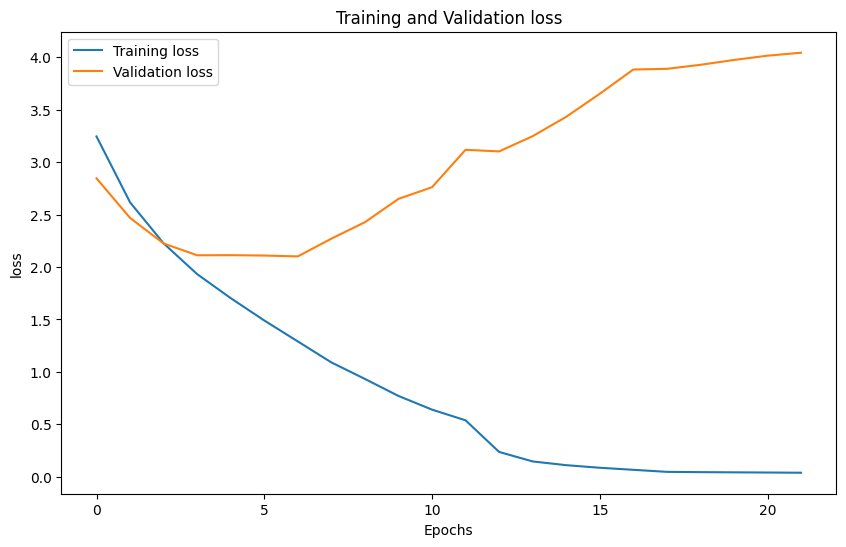

In [46]:
# plot a comparison of the combined results
plt.figure(figsize=(10, 6))
for result in combined_results:
    plt.plot(result['history']['accuracy'], label=f"{result['experiment_variable']}: {result['accuracy']:.2f}")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy')
plt.legend()
plt.show()

# plot a comparison of the combined results
plt.figure(figsize=(10, 6))
for result in combined_results:
    plt.plot(result['history']['loss'], label=f"{result['experiment_variable']}: {result['loss']:.2f}")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Comparison of Model Loss')
plt.legend()
plt.show()

# evaluate the best model
evaluate_model(best_basic_model, combined_results[0]['history'], test_images_block_1, test_labels_block_1)

### Autoencoder Modelling: For Block 1 Images
Building on your best performing model to this point, construct an autoencoder model to attempt
to reproduce input images. Discuss the appropriate use of loss functions and metrics for
evaluation.
Save the model notebook for the demo notebook and use later.


In [48]:
# load the best model
best_basic_model = load_model(MODEL_DIR_PATH+'/best_basic_model.keras')

157/157 [==============================] - 1s 7ms/step - loss: 2.1046 - accuracy: 0.4348
Test loss:  2.104644536972046
Test accuracy:  0.43479999899864197
157/157 [==============================] - 1s 7ms/step
Confusion matrix:
[[27 13  8 ...  0  4  0]
 [ 4 68  2 ...  0  6  1]
 [ 3  2 52 ...  0 20  0]
 ...
 [ 0  1  0 ... 26  3  1]
 [ 7  7 14 ...  0 57  1]
 [ 1  0  0 ...  4  1 62]]
157/157 [==============================] - 1s 8ms/step
0.4334
              precision    recall  f1-score   support

           0       0.44      0.27      0.34       100
           1       0.62      0.68      0.65       100
           2       0.50      0.52      0.51       100
           3       0.38      0.27      0.31       100
           4       0.23      0.30      0.26       100
           5       0.45      0.68      0.54       100
           6       0.43      0.48      0.45       100
           7       0.17      0.11      0.13       100
           8       0.30      0.46      0.36       100
           9 

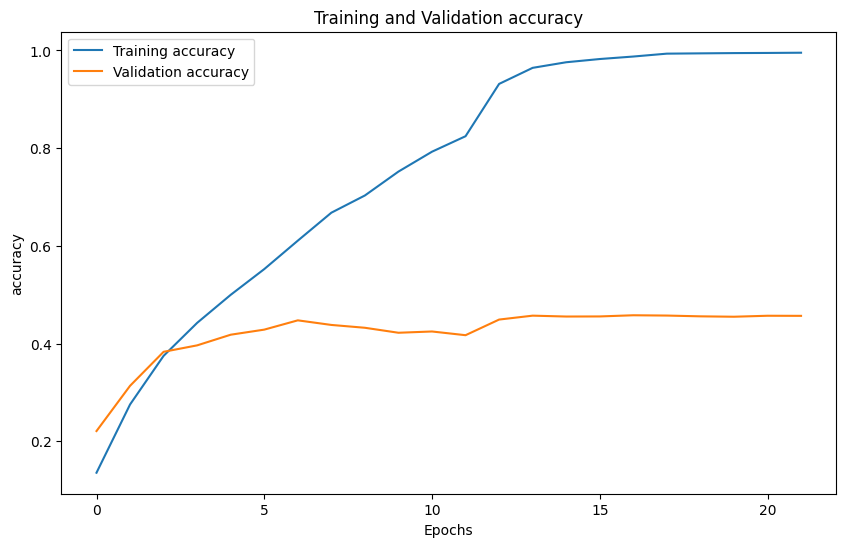

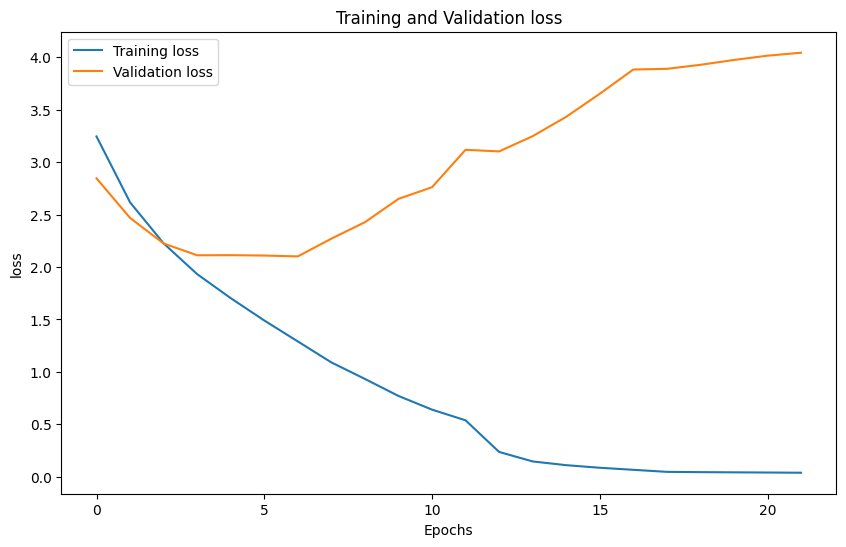

In [49]:
evaluate_model(best_basic_model, combined_results[0]['history'], test_images_block_1, test_labels_block_1)

#### Basic Decoder

In [50]:
# from tensorflow.keras.layers import Dense, Reshape, Input
# from tensorflow.keras.models import Model

# def create_decoder(latent_dim=50, 
#                    activation='relu', 
#                    final_activation='sigmoid',
#                    output_shape=(32, 32, 3)):
#     # Input latent representation
#     latent_inputs = Input(shape=(latent_dim,))
    
#     # First hidden layer
#     dense_one = Dense(32, activation=activation)(latent_inputs)
#     # Second hidden layer
#     dense_two = Dense(64, activation=activation)(dense_one)
#     # Third hidden layer
#     dense_three = Dense(128, activation=activation)(dense_two)
#     # Fourth hidden layer
#     dense_four = Dense(256, activation=activation)(dense_three)
#     # Fifth hidden layer
#     dense_five = Dense(512, activation=activation)(dense_four)

#     # Output layer (reshaping back to original input shape)
#     output_layer = Dense(output_shape[0] * output_shape[1] * output_shape[2], 
#                          activation=final_activation)(dense_five)
#     outputs = Reshape(output_shape)(output_layer)

#     decoder = Model(latent_inputs, outputs)
#     return decoder

#### CNN Decoder

In [51]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Reshape, Conv2DTranspose, UpSampling2D, Conv2D

def create_decoder(input_dim=50, 
                   activation='relu',
                   optimizer='adam',
                   final_activation='sigmoid',
                   loss_function='mse'):
    """
    Creates a decoder model to reconstruct the original image from encoded features.
    
    Parameters:
    - input_dim: The dimensionality of the encoded input vector.
    - activation: Activation function for hidden layers.
    - optimizer: Optimizer to use for compiling the model.
    - final_activation: Activation function for the output layer.
    - loss_function: Loss function to use for compiling the model.
    
    Returns:
    - A compiled Keras decoder model.
    """
    # Input layer for the encoded vector
    inputs = Input(shape=(input_dim,))
    
    # Dense layers to expand the encoded vector back
    dense1 = Dense(256, activation=activation)(inputs)
    dense2 = Dense(128, activation=activation)(dense1)
    dense3 = Dense(4 * 4 * 128, activation=activation)(dense2)
    
    # Reshape to match the feature map shape
    reshaped = Reshape((4, 4, 128))(dense3)
    
    # Decoder layers (adjusted for 32x32x3 output)
    conv1_transpose = Conv2DTranspose(128, (3, 3), activation=activation, padding='same')(reshaped)
    up1 = UpSampling2D((2, 2))(conv1_transpose)  # 8x8
    
    conv2_transpose = Conv2DTranspose(64, (3, 3), activation=activation, padding='same')(up1)
    up2 = UpSampling2D((2, 2))(conv2_transpose)  # 16x16
    
    conv3_transpose = Conv2DTranspose(32, (3, 3), activation=activation, padding='same')(up2)
    up3 = UpSampling2D((2, 2))(conv3_transpose)  # 32x32
    
    # Final convolution layer to match the original image dimensions
    output = Conv2D(3, (3, 3), activation=final_activation, padding='same')(up3)
    
    # Create and compile the model
    decoder = Model(inputs, output)
    decoder.compile(optimizer=optimizer, loss=loss_function)
    
    return decoder

In [52]:
# load the best basic model, from disk
# encoder_model = load_model('models/Part1/best_basic_model.keras')

In [53]:
# create an autoencoder model to reconstruct the images based on the best basic model
decoder = create_decoder(input_dim=50, activation='leaky_relu', final_activation='sigmoid', loss_function='mse')
decoder.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 50)]              0         
                                                                 
 dense_70 (Dense)            (None, 256)               13056     
                                                                 
 dense_71 (Dense)            (None, 128)               32896     
                                                                 
 dense_72 (Dense)            (None, 2048)              264192    
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 128)         147584    
 anspose)                                                        
                                                          

In [54]:
# Combine encoder and decoder into an autoencoder
encoded_input = best_basic_model.input
encoded_output = best_basic_model(encoded_input)  
decoded_output = decoder(encoded_output)  

# Create the model
autoencoder = Model(inputs=encoded_input, outputs=decoded_output)

# Compile the model
autoencoder.compile(optimizer=OPTIMIZER, loss='mse')

# Display the autoencoder model summary
autoencoder.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 model_14 (Functional)       (None, 50)                286898    
                                                                 
 model_17 (Functional)       (None, 32, 32, 3)         550851    
                                                                 
Total params: 837749 (3.20 MB)
Trainable params: 837749 (3.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
# train the autoencoder model
autoencoder_history = autoencoder.fit(train_images_block_1, train_images_block_1, 
                                      batch_size=BATCH_SIZE, 
                                      epochs=EPOCHS, 
                                      validation_split=VALIDATION_SPLIT, 
                                      callbacks=callbacks)

# save the autoencoder model
autoencoder.save(MODEL_DIR_PATH+'/basic_autoencoder_model.keras')

Epoch 1/50
625/625 [==============================] - 23s 36ms/step - loss: 0.0283 - val_loss: 0.0223 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 23s 36ms/step - loss: 0.0204 - val_loss: 0.0196 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 22s 35ms/step - loss: 0.0184 - val_loss: 0.0180 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 21s 34ms/step - loss: 0.0176 - val_loss: 0.0175 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 22s 35ms/step - loss: 0.0170 - val_loss: 0.0174 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 22s 35ms/step - loss: 0.0165 - val_loss: 0.0164 - lr: 0.0010
Epoch 7/50
625/625 [==============================] - 22s 35ms/step - loss: 0.0159 - val_loss: 0.0161 - lr: 0.0010
Epoch 8/50
625/625 [==============================] - 21s 34ms/step - loss: 0.0157 - val_loss: 0.0159 - lr: 0.0010
Epoch 9/50
625/625 [==============================] - 22s 35ms/step - loss: 0.01

157/157 [==============================] - 2s 13ms/step


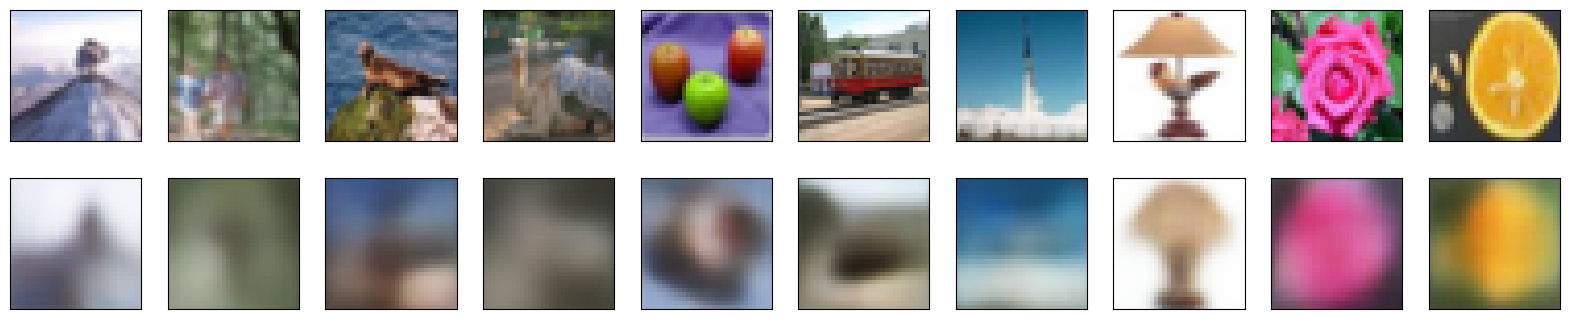

In [56]:
# display the decoded images
decoded_images = autoencoder.predict(test_images_block_1)

# display the first 10 images
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(test_images_block_1[i])
    # get the label names from the label encoder
    # ax.set_title(le.inverse_transform([np.argmax(test_labels_block_1[i])]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(decoded_images[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Transfer Learning for Block 2 Images
Using the two models saved above, investigate the use of transfer learning to build a network for
Block 2 images. Compare results for Transfer Learning based implementations to those for afromscratch implementation equivalent to the transferred model.

#### Transfer Learning from Basic Model Phase

In [58]:
# Load the pre-trained models
best_basic_model = load_model(MODEL_DIR_PATH+'/best_basic_model.keras')
autoencoder = load_model(MODEL_DIR_PATH+'/basic_autoencoder_model.keras')

In [59]:
best_basic_model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_42 (Conv2D)          (None, 32, 32, 32)           896       ['input_15[0][0]']            
                                                                                                  
 max_pooling2d_42 (MaxPooli  (None, 16, 16, 32)           0         ['conv2d_42[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_43 (Conv2D)          (None, 16, 16, 64)           18496     ['max_pooling2d_42[0][0

In [60]:
autoencoder.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 model_14 (Functional)       (None, 50)                286898    
                                                                 
 model_17 (Functional)       (None, 32, 32, 3)         550851    
                                                                 
Total params: 837749 (3.20 MB)
Trainable params: 837749 (3.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [61]:
# Use the best_basic_model as the encoder
encoder = Model(inputs=best_basic_model.input, outputs=best_basic_model.output)

# Display the encoder structure
encoder.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_42 (Conv2D)          (None, 32, 32, 32)           896       ['input_15[0][0]']            
                                                                                                  
 max_pooling2d_42 (MaxPooli  (None, 16, 16, 32)           0         ['conv2d_42[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_43 (Conv2D)          (None, 16, 16, 64)           18496     ['max_pooling2d_42[0][0

In [62]:
decoder.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 50)]              0         
                                                                 
 dense_70 (Dense)            (None, 256)               13056     
                                                                 
 dense_71 (Dense)            (None, 128)               32896     
                                                                 
 dense_72 (Dense)            (None, 2048)              264192    
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 128)         147584    
 anspose)                                                        
                                                          

In [72]:
def create_transfer_model(encoder, decoder):
    """
    Creates a transfer model by combining the encoder and decoder.

    Parameters:
    - encoder: The encoder model (outputs latent space of shape (None, 50)).
    - decoder: The decoder model (expects input of shape (None, 50)).

    Returns:
    - The combined transfer model.
    """
    # freeze the encoder and decoder layers
    encoder.trainable = False
    decoder.trainable = False

    # Input for the transfer model
    encoded_input = encoder.input  # Encoder input: (None, 32, 32, 3)

    # Pass input through the encoder to get the latent representation
    latent_output = encoder.output  # Encoder output: (None, 50)

    # Pass the latent representation to the decoder
    decoded_output = decoder(latent_output)  # Decoder output: (None, 32, 32, 3)

    # Combine into a single model
    transfer_model = Model(inputs=encoded_input, outputs=decoded_output)

    return transfer_model


In [73]:
encoder = Model(inputs=best_basic_model.input, outputs=best_basic_model.output)


In [74]:
transfer_model = create_transfer_model(encoder, decoder)
transfer_model.compile(optimizer=OPTIMIZER, loss='mse')
transfer_model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_42 (Conv2D)          (None, 32, 32, 32)           896       ['input_15[0][0]']            
                                                                                                  
 max_pooling2d_42 (MaxPooli  (None, 16, 16, 32)           0         ['conv2d_42[0][0]']           
 ng2D)                                                                                            
                                                                                                  


 conv2d_43 (Conv2D)          (None, 16, 16, 64)           18496     ['max_pooling2d_42[0][0]']    
                                                                                                  
 max_pooling2d_43 (MaxPooli  (None, 8, 8, 64)             0         ['conv2d_43[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_44 (Conv2D)          (None, 8, 8, 128)            73856     ['max_pooling2d_43[0][0]']    
                                                                                                  
 max_pooling2d_44 (MaxPooli  (None, 4, 4, 128)            0         ['conv2d_44[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 flatten_1

In [75]:
transfer_model_history = transfer_model.fit(train_images_block_2, train_images_block_2, 
                                            batch_size=BATCH_SIZE, 
                                            epochs=EPOCHS, 
                                            validation_split=VALIDATION_SPLIT, 
                                            callbacks=callbacks)

Epoch 1/50
625/625 [==============================] - 12s 19ms/step - loss: 0.0125 - val_loss: 0.0144 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 11s 18ms/step - loss: 0.0125 - val_loss: 0.0144 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 12s 18ms/step - loss: 0.0125 - val_loss: 0.0144 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 11s 18ms/step - loss: 0.0125 - val_loss: 0.0144 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 11s 18ms/step - loss: 0.0125 - val_loss: 0.0144 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 0.0125 - val_loss: 0.0144 - lr: 0.0010
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 0.0125 - val_loss: 0.0144 - lr: 1.0000e-04
Epoch 8/50
625/625 [==============================] - 11s 18ms/step - loss: 0.0125 - val_loss: 0.0144 - lr: 1.0000e-04
Epoch 9/50
625/625 [==============================] - 12s 19ms/step - lo

In [134]:
transfer_model.evaluate(test_images_block_2, test_images_block_2)
# save the transfer model
transfer_model.save(MODEL_DIR_PATH+'/basic_transfer_model.keras')

157/157 [==============================] - 3s 17ms/step - loss: 0.0147


157/157 [==============================] - 2s 16ms/step


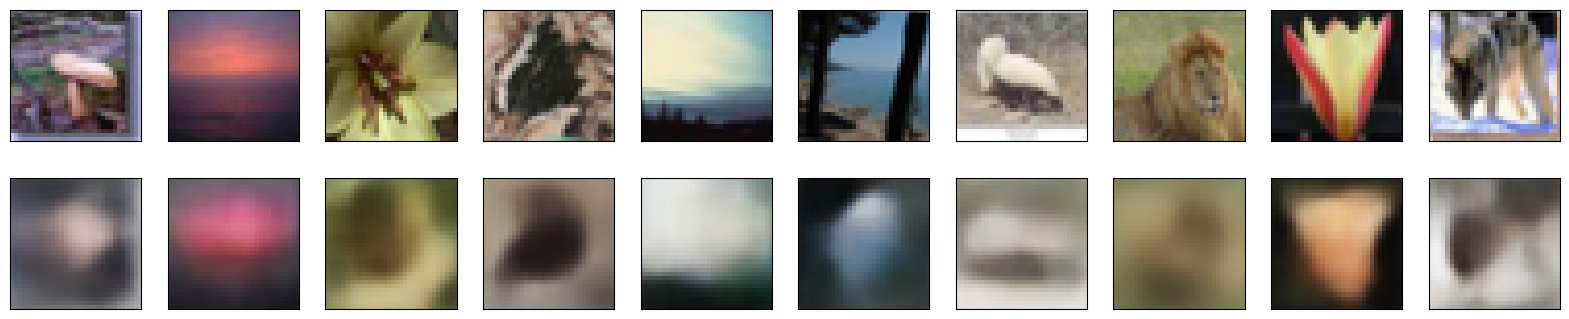

In [85]:
# display the decoded images
decoded_images_2 = transfer_model.predict(test_images_block_2)

# display the first 10 images
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(test_images_block_2[i])
    # get the label names from the label encoder
    # ax.set_title(le.inverse_transform([np.argmax(test_labels_block_1[i])]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(decoded_images_2[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [124]:
# create a new model trained on the block 2 data to compate with the transfer model
block_2_model = create_model(activation='relu', final_activation='softmax')
block_2_model_history = block_2_model.fit(train_images_block_2, train_labels_block_2, 
                                          batch_size=BATCH_SIZE, 
                                          epochs=EPOCHS, 
                                          validation_split=VALIDATION_SPLIT, 
                                          callbacks=callbacks)


Epoch 1/50
625/625 [==============================] - 11s 17ms/step - loss: 3.3772 - accuracy: 0.1165 - val_loss: 2.9473 - val_accuracy: 0.1996 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 10s 17ms/step - loss: 2.7278 - accuracy: 0.2474 - val_loss: 2.6575 - val_accuracy: 0.2840 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 11s 17ms/step - loss: 2.4302 - accuracy: 0.3205 - val_loss: 2.3988 - val_accuracy: 0.3358 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 10s 16ms/step - loss: 2.1777 - accuracy: 0.3826 - val_loss: 2.2259 - val_accuracy: 0.3870 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 10s 16ms/step - loss: 1.9875 - accuracy: 0.4300 - val_loss: 2.1795 - val_accuracy: 0.4072 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 10s 16ms/step - loss: 1.8210 - accuracy: 0.4726 - val_loss: 2.1272 - val_accuracy: 0.4212 - lr: 0.0010
Epoch 7/50
625/625 [==============================] - 10s 

157/157 [==============================] - 1s 8ms/step - loss: 1.9529 - accuracy: 0.4562
Test loss:  1.952925443649292
Test accuracy:  0.4562000036239624
157/157 [==============================] - 1s 8ms/step
Confusion matrix:
[[59  2  0 ...  2  0  0]
 [ 0 17  3 ...  2  0  3]
 [ 0  0 77 ...  0  0  0]
 ...
 [ 3  0  0 ... 28  1  2]
 [ 0  0  0 ...  5 33  3]
 [ 0  0  1 ...  3  1 41]]
157/157 [==============================] - 1s 7ms/step
0.4562
              precision    recall  f1-score   support

           0       0.77      0.59      0.67       100
           1       0.29      0.17      0.21       100
           2       0.52      0.77      0.62       100
           3       0.28      0.07      0.11       100
           4       0.43      0.43      0.43       100
           5       0.18      0.31      0.23       100
           6       0.44      0.37      0.40       100
           7       0.20      0.09      0.12       100
           8       0.38      0.41      0.39       100
           9  

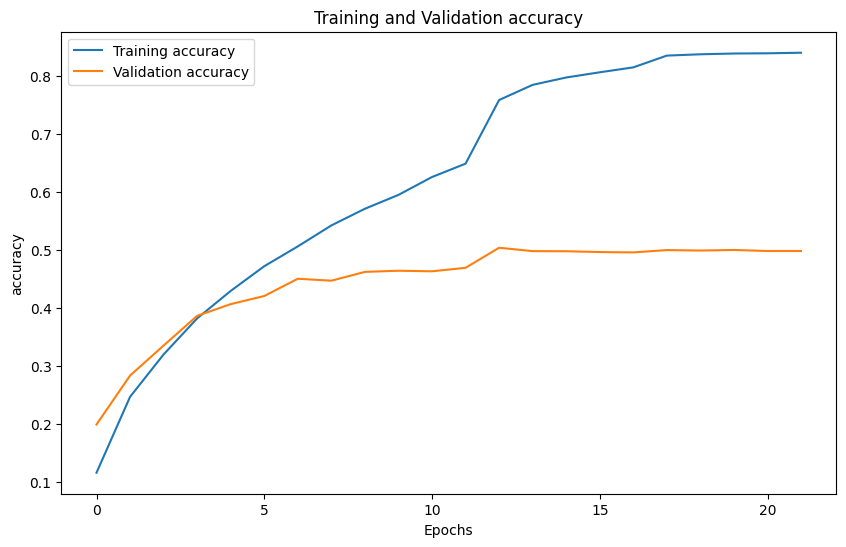

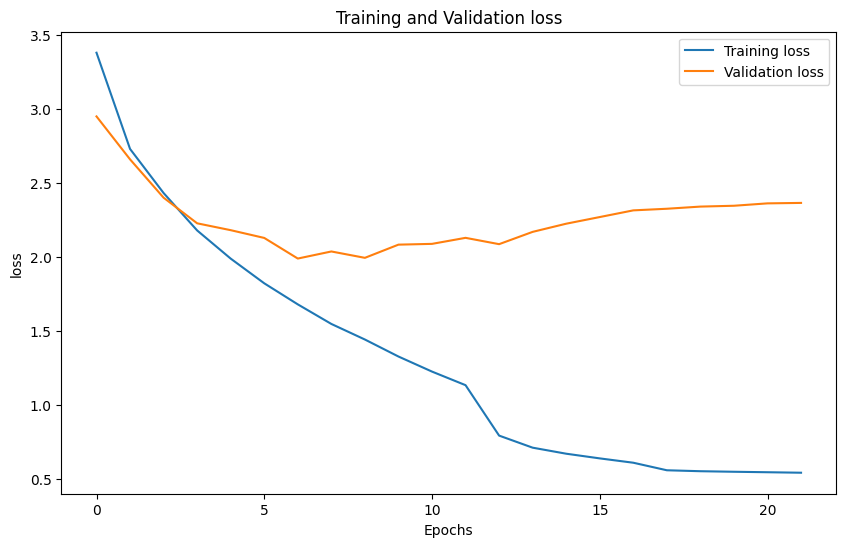

In [125]:
# evaluate the block 2 model
evaluate_model(block_2_model, block_2_model_history.history, test_images_block_2, test_labels_block_2)

In [ ]:
# create an decoder model to reconstruct the images based on the new block 2 model
block_2_decoder = create_decoder(input_dim=50, activation='relu', final_activation='sigmoid', loss_function='mse')
block_2_decoder.summary()


Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 50)]              0         
                                                                 
 dense_90 (Dense)            (None, 256)               13056     
                                                                 
 dense_91 (Dense)            (None, 128)               32896     
                                                                 
 dense_92 (Dense)            (None, 2048)              264192    
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 4, 4, 128)         147584    
 Transpose)                                                      
                                                          

In [ ]:
# Combine encoder and decoder into an autoencoder
encoded_input_2 = block_2_model.input
encoded_output_2 = block_2_model(encoded_input_2)  
decoded_output_2 = decoder(encoded_output_2)  

# Create the model
autoencoder_2 = Model(inputs=encoded_input_2, outputs=decoded_output_2)

# Compile the model
autoencoder_2.compile(optimizer=OPTIMIZER, loss='mse')

# Display the autoencoder model summary
autoencoder_2.summary()


Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 model_28 (Functional)       (None, 50)                278578    
                                                                 
 model_17 (Functional)       (None, 32, 32, 3)         550851    
                                                                 
Total params: 829429 (3.16 MB)
Trainable params: 278578 (1.06 MB)
Non-trainable params: 550851 (2.10 MB)
_________________________________________________________________


Epoch 1/50
625/625 [==============================] - 23s 36ms/step - loss: 0.0459 - val_loss: 0.0409 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 23s 37ms/step - loss: 0.0398 - val_loss: 0.0397 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 23s 36ms/step - loss: 0.0390 - val_loss: 0.0392 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 22s 36ms/step - loss: 0.0386 - val_loss: 0.0389 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 23s 36ms/step - loss: 0.0383 - val_loss: 0.0387 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 22s 36ms/step - loss: 0.0381 - val_loss: 0.0386 - lr: 0.0010
Epoch 7/50
625/625 [==============================] - 22s 35ms/step - loss: 0.0379 - val_loss: 0.0384 - lr: 0.0010
Epoch 8/50
625/625 [==============================] - 22s 34ms/step - loss: 0.0378 - val_loss: 0.0382 - lr: 0.0010
Epoch 9/50
625/625 [==============================] - 22s 35ms/step - loss: 0.03

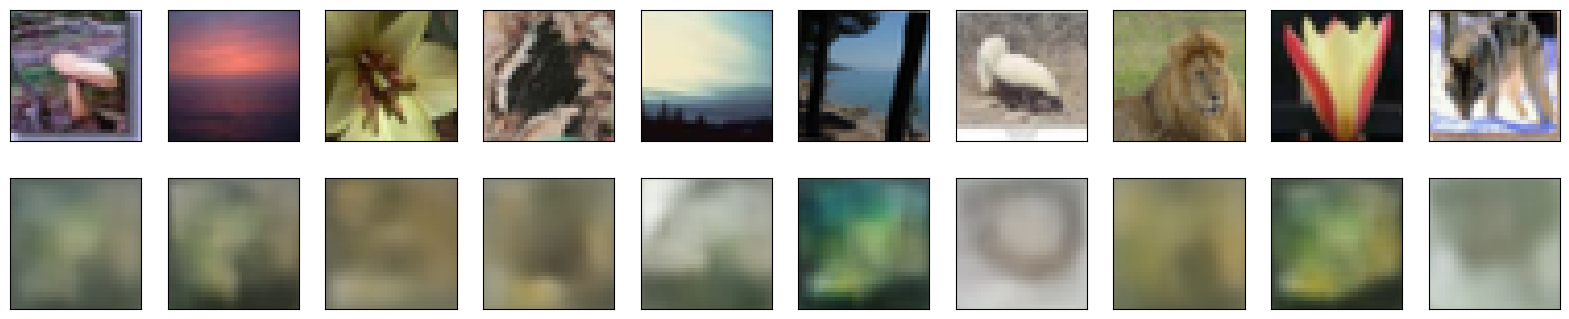

In [ ]:
# train the autoencoder model
autoencoder_2_history = autoencoder_2.fit(train_images_block_2, train_images_block_2, 
                                          batch_size=BATCH_SIZE, 
                                          epochs=EPOCHS, 
                                          validation_split=VALIDATION_SPLIT, 
                                          callbacks=callbacks)


157/157 [==============================] - 2s 15ms/step


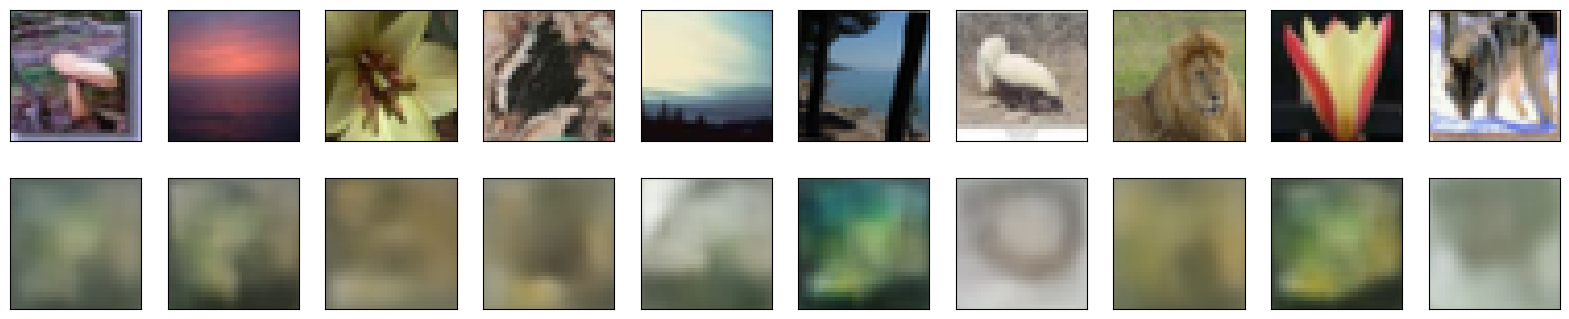

In [130]:
# display the decoded images
decoded_images_2 = autoencoder_2.predict(test_images_block_2)

# display the first 10 images
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(test_images_block_2[i])
    # get the label names from the label encoder
    # ax.set_title(le.inverse_transform([np.argmax(test_labels_block_1[i])]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(decoded_images_2[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [136]:
autoencoder_2.evaluate(test_images_block_2, test_images_block_2)

157/157 [==============================] - 2s 16ms/step - loss: 0.0376


0.03759882599115372

In [131]:
# save the autoencoder model
autoencoder_2.save(MODEL_DIR_PATH+'/block_2_autoencoder_model.keras')